### Keras

In [ ]:
import keras
from keras.layers import *
import numpy as np
import matplotlib.pyplot as plt
import keras.utils
import tensorflow as tf
from keras import layers

In [ ]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
    # Upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # Concatenate
    x = layers.concatenate([x, conv_features])
    # Dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

In [ ]:
def build_unet_model(num_classes):
  inputs = layers.Input(shape=(160,160,3))
  # энкодер
  # понижающая свертка
  f1, p1 = downsample_block(inputs, 64)
  f2, p2 = downsample_block(p1, 128)
  f3, p3 = downsample_block(p2, 256)
  f4, p4 = downsample_block(p3, 512)
  # 5 бутылочное горлышко
  bottleneck = double_conv_block(p4,1024)
  # декодер
  # повышение дискретизации
  u6 = upsample_block(bottleneck,f4,512)
  u7 = upsample_block(u6,f3,256)
  u8 = upsample_block(u7,f2,128)
  u9 = upsample_block(u8,f1,64)
  # выходы
  outputs = layers.Conv2D(num_classes, 3, padding = "same", activation = "softmax")(u9)
  unet_model = tf.keras.Model(inputs, outputs, name='U-Net')
  return unet_model


In [ ]:
unet_model = build_unet_model(3)
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorial_crossentropy",
                   metrics=["accuracy"])

In [ ]:
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 160, 160,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 160, 160,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 80, 80,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 80, 80,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 80, 80,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 80, 80,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 40, 40,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 40, 40,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 40, 40,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 40, 40,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 20, 20,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 20, 20,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 20, 20,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 20, 20,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 10, 10,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 10, 10,    │          0 │ max_pooling2d_3[

 Total params: 34,515,011 (131.66 MB)

 Trainable params: 34,515,011 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

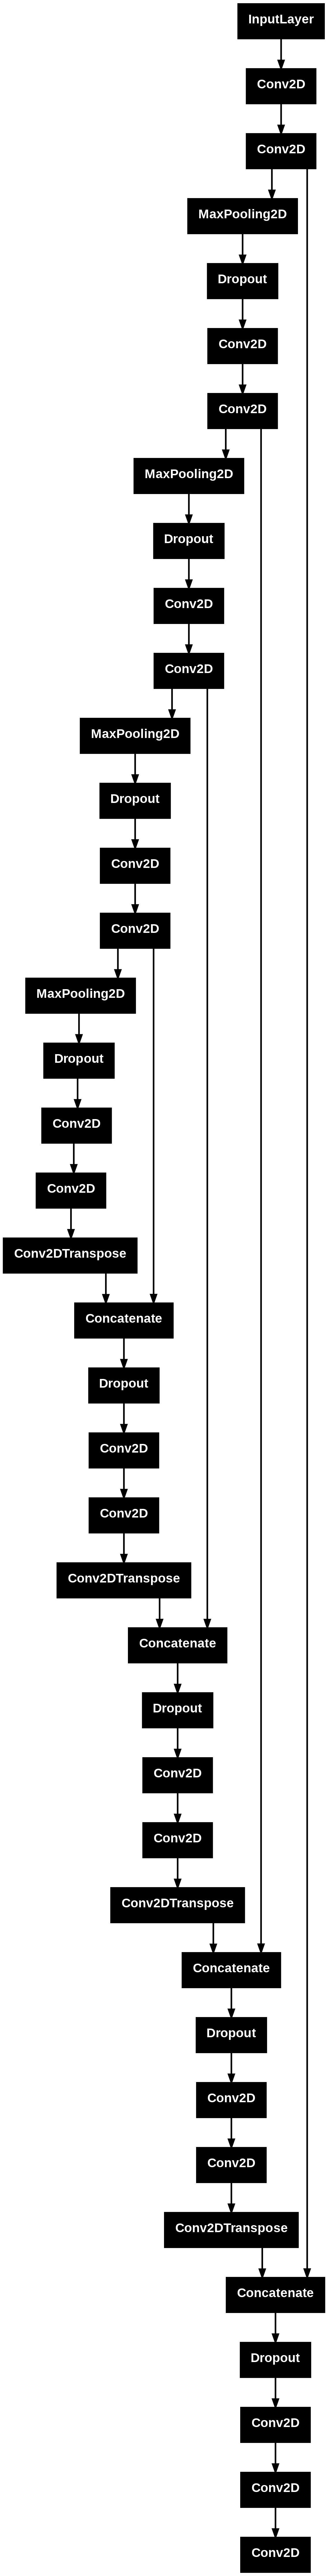

In [ ]:
keras.utils.plot_model(unet_model)

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

!curl -O https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz

--2025-05-23 07:31:39--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-05-23 07:31:40--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz.1’

images.tar.gz.1     100%[===================>] 755.23M  25.3MB/s    in 31s     

2025-05-23 07:32:11 (24.5 MB/s) - ‘images.tar.gz.1’ saved [791918971/791918971]

--2025-05-23 07:32:12--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving w

In [ ]:
!ls

annotations.tar.gz  images.tar.gz  model.png  sample_data


In [ ]:
!ls -lh

total 774M
-rw-r--r-- 1 root root  187 May 23 07:32 annotations.tar.gz
-rw-r--r-- 1 root root  19M Jul 29  2022 annotations.tar.gz.1
-rw-r--r-- 1 root root  187 May 23 07:32 images.tar.gz
-rw-r--r-- 1 root root 756M Jul 29  2022 images.tar.gz.1
-rw-r--r-- 1 root root 247K May 23 07:30 model.png
drwxr-xr-x 1 root root 4.0K May 14 13:38 sample_data


In [ ]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [ ]:
!pip install pillow

In [ ]:
import os
from PIL import ImageOps
from IPython.display import display, Image
from keras.preprocessing.image import load_img

In [ ]:
input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 2

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

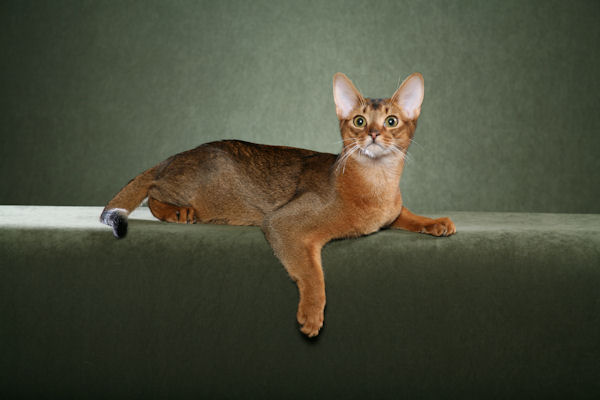

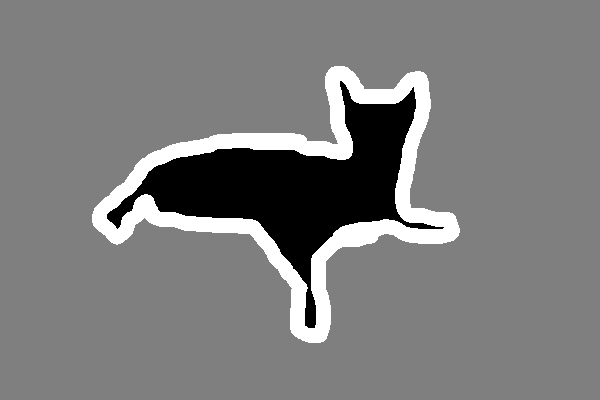

In [ ]:
# отображаем первый рисунок и маску, чтобы проверить их соответствие
display(Image(filename=input_img_paths[0]))
img = ImageOps.autocontrast(load_img(target_img_paths[0]))
display(img)

In [ ]:
def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """
    Возвращает набор данных TF.
    """

    def load_img_masks(input_img_path, target_img_path):
        # Загрузка и предобработка входного изображения
        input_img = tf.io.read_file(input_img_path)
        input_img = tf.image.decode_png(input_img, channels=3)
        input_img = tf.image.resize(input_img, img_size)
        input_img = tf.image.convert_image_dtype(input_img, "float32")

        # Загрузка и предобработка целевого изображения (маски)
        target_img = tf.io.read_file(target_img_path)
        target_img = tf.image.decode_png(target_img, channels=1)
        target_img = tf.image.resize(target_img, img_size, method="nearest")
        target_img = tf.image.convert_image_dtype(target_img, "uint8")

        # Метки основной истины — 1, 2, 3. Вычтем единицу, чтобы получить 0, 1, 2
        target_img -= 1

        return input_img, target_img

    # Для более быстрой отладки ограничим размер данных
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]

    # Создаем TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf.data.AUTOTUNE)

    # Группируем данные в батчи
    return dataset.batch(batch_size)

In [ ]:
import random

In [ ]:
limit = 10

# Разделите наши пути img на обучающий и проверочный набор
val_samples = limit
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Создать экземпляр набора данных для каждого разделения
# Ограничьте входные файлы в `max_dataset_len` для ускорения времени обучения эпохи
# Удалите аргумент `max_dataset_len` при работе с полным набором данных
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=limit,
)

valid_dataset = get_dataset(
    batch_size,
    img_size,
    val_input_img_paths,
    val_target_img_paths,
)

In [ ]:
import sys
from tensorflow import io as tf_io
sys.getsizeof(tf_io.read_file(train_input_img_paths[0]))

184

In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160, 160, 1), dtype=tf.uint8, name=None))>

In [ ]:
sys.getsizeof(train_dataset)

56

In [ ]:
from tensorflow.keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, [1, 2, 3]) + K.sum(y_pred, [1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def jaccard_coef(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    jac = (intersection + 1.) / (union - intersection + 1.)
    return K.mean(jac)

def dice_coef(y_true, y_pred, smooth=1.):
    y_true = K.cast(y_true, 'float32')
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

In [ ]:
unet_model = build_unet_model(3)
unet_model.compile(optimizer='adam',
                   loss="sparse_categorical_crossentropy",
                   metrics=[iou_coef])
epochs = 5
unet_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    verbose=2,
)

Epoch 1/5
5/5 - 61s - 12s/step - iou_coef: 0.8675 - loss: 177.4173 - val_iou_coef: 0.7970 - val_loss: 42.7754
Epoch 2/5
5/5 - 80s - 16s/step - iou_coef: 0.8675 - loss: 24.7038 - val_iou_coef: 0.7970 - val_loss: 9.7084
Epoch 3/5
5/5 - 47s - 9s/step - iou_coef: 0.8675 - loss: 8.8087 - val_iou_coef: 0.7970 - val_loss: 2.6491
Epoch 4/5
5/5 - 81s - 16s/step - iou_coef: 0.8675 - loss: 3.1534 - val_iou_coef: 0.7970 - val_loss: 1.7502
Epoch 5/5
5/5 - 45s - 9s/step - iou_coef: 0.8675 - loss: 1.8197 - val_iou_coef: 0.7970 - val_loss: 1.3768


In [ ]:
unet_model = build_unet_model(3)
unet_model.compile(optimizer='rmsprop',
                   loss="sparse_categorical_crossentropy",
                   metrics=[jaccard_coef, dice_coef])

In [ ]:
epochs = 5
unet_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    verbose=2
)

In [ ]:
from PIL import Image as Im

def display_mask(i):
    """Быстрая утилита для отображения прогноза модели"""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    img = img.resize((500, 500), Im.LANCZOS)
    display(img)

def check_one_image(i):
    # Отображение входного изображения
    display(Image(filename=val_input_img_paths[i]))

    # Отображение истинной маски
    img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
    display(img)

    # Отображение предсказанной маски
    display_mask(i)



In [ ]:
val_preds = unet_model.predict(valid_dataset)

In [ ]:
for i in range(3):  # Проверяем первые три изображения
    print(f"Изображение {i + 1}:")
    check_one_image(i)
    print("-" * 50)

In [ ]:
!pip install segmentation_models

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

# Segmentation Models: using `tf.keras` framework.

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
model_dice_loss.compile(loss=dice_loss)
epochs = 3
model_dice_loss.fit(
    train_dataset,
    epochs=epochs,
    verbose=2,
)

model_focal_loss = build_unet_model(3)
model_focal_loss.compile(loss=focal_loss)
epochs = 3
model_focal_loss.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    verbose=2,
)

### PyTorch

In [ ]:
import torch
import torch.nn as nn

nX, nH, nY = 2, 5, 1
model = nn.Sequential(
    nn.Linear(nX, nH),
    nn.Sigmoid(),
    nn.Linear(nH, nY),
    nn.Sigmoid()
)

In [ ]:
class TwoLayersNet(nn.Module):
    def __init__(self, nX, nH, nY):
        super(TwoLayersNet, self).__init__()

        self.fc1 = nn.Linear(nX, nH)
        self.fc2 = nn.Linear(nH, nY)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.Sigmoid()(x)
        x = self.fc2(x)
        x = nn.Sigmoid()(x)
        return x

model = TwoLayersNet(2, 5, 1)
